In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn shap


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---

In [3]:
import pandas as pd

df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


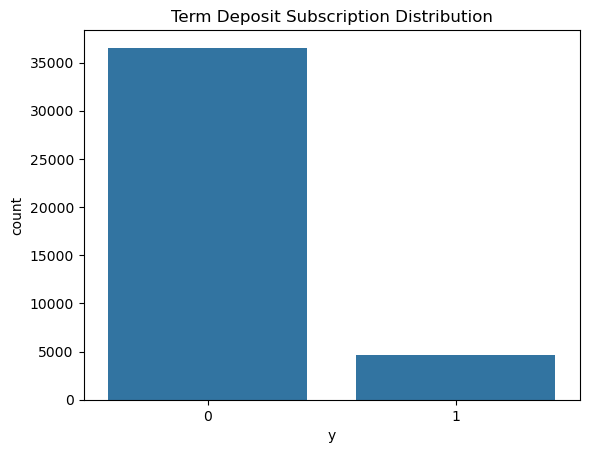

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='y', data=df)
plt.title("Term Deposit Subscription Distribution")
plt.show()


In [11]:
print(df.isnull().sum())


age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                 41188
dtype: int64


C:\Users\ABC\AppData\Local\Temp\ipykernel_9240\4270619324.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Number of samples after preprocessing: 41188
Logistic Regression F1 Score: 0.5193220338983051
Confusion Matrix:
 [[7146  164]
 [ 545  383]]
Random Forest F1 Score: 0.6019417475728155
Confusion Matrix:
 [[7086  224]
 [ 432  496]]


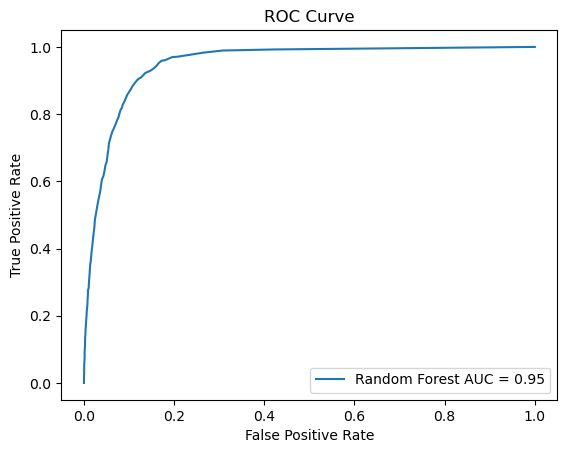

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap

# ------------------------------
# 1️⃣ Load Dataset
# ------------------------------
df = pd.read_csv("bank-additional-full.csv", sep=';')

# ------------------------------
# 2️⃣ Handle Missing / 'unknown' Values
# ------------------------------
# Instead of dropping, we treat 'unknown' as a separate category for categorical features
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols = [col for col in categorical_cols if col != 'y']

for col in categorical_cols:
    df[col] = df[col].astype(str)  # ensure string
    df[col] = df[col].fillna('unknown')  # fill NaN with 'unknown'

# For numeric columns, fill NaN with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# ------------------------------
# 3️⃣ Encode Categorical Columns
# ------------------------------
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Encode target
df['y'] = df['y'].map({'yes':1, 'no':0})

# ------------------------------
# 4️⃣ Features & Target
# ------------------------------
X = df.drop('y', axis=1)
y = df['y']

# Check number of samples
print("Number of samples after preprocessing:", df.shape[0])
if df.shape[0] == 0:
    raise ValueError("No data left after preprocessing!")

# ------------------------------
# 5️⃣ Train-Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 6️⃣ Standardize Features (for Logistic Regression)
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 7️⃣ Logistic Regression
# ------------------------------
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# ------------------------------
# 8️⃣ Random Forest
# ------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ------------------------------
# 9️⃣ ROC Curve Example (RF)
# ------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Random Forest AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ------------------------------
# 10️⃣ SHAP Explainability
# ------------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

for i in range(5):
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][i],
        X_test.iloc[i],
        matplotlib=True
    )
